# Определение возраста покупателей

# Описание проекта

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:**
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
- Нужно построить модель, которая по фотографии определит приблизительный возраст человека. 
- В нашем распоряжении набор фотографий людей с указанием возраста.


## Импорт необходимых библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [2]:
# Загрузка CSV файла
labels_path = '/datasets/faces/labels.csv'
labels_df = pd.read_csv(labels_path)

## Исследовательский анализ данных

### Проведем исследовательский анализ данных:
- Посмотрим на размер выборки.
- Построим график распределения возраста в выборке.
- Напечатаем на экране 10–15 фотографий и построим, как устроен датасет.
- Сделаем выводы о том, как результаты исследования повлияют на обучение модели.

In [3]:
# Посмотрим на первые несколько строк данных
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Размер выборки
num_samples = labels_df.shape[0]
print(f'Размер выборки: {num_samples} образец')

Размер выборки: 7591 образец


In [5]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Построим график распределения возраста.

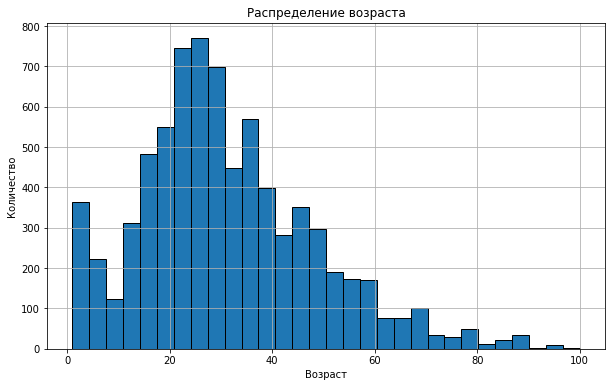

In [7]:
# График распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(labels_df['real_age'], bins=30, edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

### Просмотр фотографий

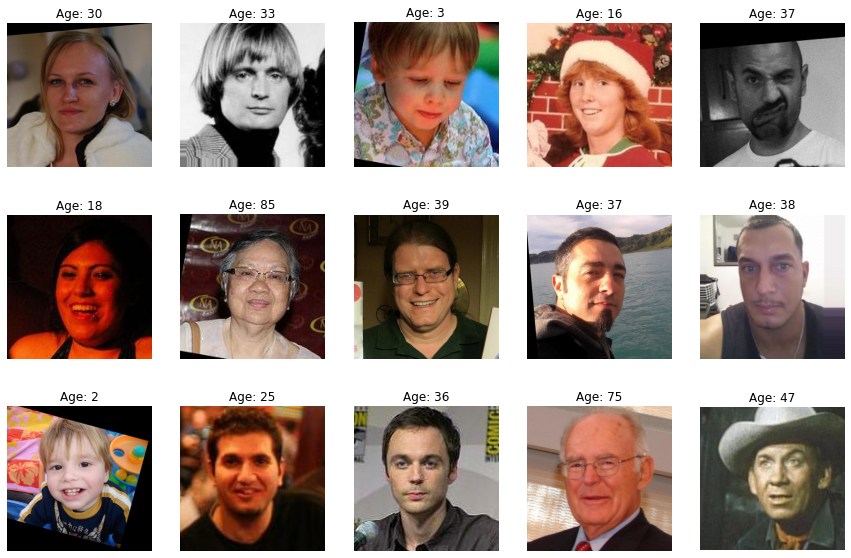

In [8]:
# Путь к папке с изображениями
image_dir = '/datasets/faces/final_files/'

# Выведем 10-15 случайных изображений
sample_images = labels_df.sample(15)

plt.figure(figsize=(15, 10))
for idx, row in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row[1]['file_name'])
    img = mpimg.imread(img_path)
    plt.subplot(3, 5, idx + 1, label=f'Image_{idx}')
    plt.imshow(img)
    plt.title(f"Age: {row[1]['real_age']}")
    plt.axis('off')
plt.show()

### Вывод

1. Размер выборки
- Датасет содержит 7591 образец, что является достаточным количеством данных для модели. Это позволяет предположить, что модель сможет хорошо обобщать на основе доступных данных, при условии, что данные достаточно разнообразны и репрезентативны.

2. Распределение возраста
- Гистограмма распределения возраста показывает, что данные неравномерно распределены. Наибольшее количество  находится в возрасте около 30 лет, что соответствует среднему возрасту в выборке (31.2 года).

- Преобладание в возрасте 20-40 лет: Большинство находятся в этом диапазоне, что может повлиять на обучение модели, делая её более точной в прогнозировании возрастов именно в этом интервале.

- Меньше данных для крайних возрастов: Заметно меньше данных для детей (младше 10 лет) и пожилых людей (старше 70 лет). Это может привести к менее точным прогнозам для этих возрастных категорий.

3. Информация о датасете
- Датасет состоит из двух колонок: file_name и real_age.

    - file_name (7591 non-null object): Имена файлов изображений.
    - real_age (7591 non-null int64): Реальные возраста, соответствующие этим изображениям.
    - Пропусков нет.
    
4. Примеры данных
- Предоставлены изображения людей разного возраста, подписаны реальные возраста, набор подтверждает  разнообразие возрастов, представленных в датасете.

5. Влияние на обучение модели
- Сильная сторона: Большое количество данных для возрастов от 20 до 40 лет означает, что модель будет более точной для этой возрастной группы.
- Слабая сторона: Ограниченное количество данных для крайних возрастных групп (дети и пожилые люди) может привести к менее точным предсказаниям для этих возрастов.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=1. / 255,
        validation_split=0.25
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return datagen_flow


def load_test(path, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    model.summary()

    return model


def train_model(model, train_datagen_flow, test_datagen_flow,
                epochs=30, steps_per_epoch=None, validation_steps=None):
    steps_per_epoch = steps_per_epoch or (train_datagen_flow.samples // train_datagen_flow.batch_size)
    validation_steps = validation_steps or (test_datagen_flow.samples // test_datagen_flow.batch_size)

    history = model.fit(train_datagen_flow,
                        validation_data=test_datagen_flow,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        verbose=2)

    return model




```

```

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 9s
   65536/94765736 [..............................] - ETA: 1:14
  262144/94765736 [..............................] - ETA: 41s 
  802816/94765736 [..............................] - ETA: 19s
 2211840/94765736 [..............................] - ETA: 9s 
 4603904/94765736 [>.............................] - ETA: 5s
 8708096/94765736 [=>............................] - ETA: 3s
13287424/94765736 [===>..........................] - ETA: 2s
16924672/94765736 [====>.........................] - ETA: 1s
20660224/94765736 [=====>........................] - ETA: 1s
25034752/94765736 [======>.......................] - ETA: 1s
29138944/94765736 [========>.....................] - ETA: 1s
32800768/94765736 [=========>....................] - ETA: 1s
37011456/94765736 [==========>...................] - ETA: 1s
41213952/94765736 [============>.................] - ETA: 0s
45170688/94765736 [=============>................] - ETA: 0s
49340416/94765736 [==============>...............] - ETA: 0s
53280768/94765736 [===============>..............] - ETA: 0s
57393152/94765736 [=================>............] - ETA: 0s
61423616/94765736 [==================>...........] - ETA: 0s
65617920/94765736 [===================>..........] - ETA: 0s
69345280/94765736 [====================>.........] - ETA: 0s
73498624/94765736 [======================>.......] - ETA: 0s
77742080/94765736 [=======================>......] - ETA: 0s
81469440/94765736 [========================>.....] - ETA: 0s
85901312/94765736 [==========================>...] - ETA: 0s
90013696/94765736 [===========================>..] - ETA: 0s
93732864/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
Train for 177 steps, validate for 59 steps
Epoch 1/30
177/177 - 113s - loss: 257.7336 - mean_absolute_error: 11.9309 - val_loss: 513.9055 - val_mean_absolute_error: 17.5668
Epoch 2/30
177/177 - 103s - loss: 139.6695 - mean_absolute_error: 8.9791 - val_loss: 306.1307 - val_mean_absolute_error: 12.9727
Epoch 3/30
177/177 - 109s - loss: 114.8590 - mean_absolute_error: 8.1381 - val_loss: 250.5637 - val_mean_absolute_error: 11.7274
Epoch 4/30
177/177 - 108s - loss: 104.2888 - mean_absolute_error: 7.7584 - val_loss: 141.9331 - val_mean_absolute_error: 9.0218
Epoch 5/30
177/177 - 109s - loss: 91.8031 - mean_absolute_error: 7.2886 - val_loss: 120.2255 - val_mean_absolute_error: 8.3739
Epoch 6/30
177/177 - 107s - loss: 86.0916 - mean_absolute_error: 7.0545 - val_loss: 106.2154 - val_mean_absolute_error: 7.7487
Epoch 7/30
177/177 - 108s - loss: 79.5224 - mean_absolute_error: 6.7757 - val_loss: 122.4259 - val_mean_absolute_error: 8.0631
Epoch 8/30
177/177 - 108s - loss: 75.6842 - mean_absolute_error: 6.6546 - val_loss: 112.4097 - val_mean_absolute_error: 8.2011
Epoch 9/30
177/177 - 109s - loss: 70.6189 - mean_absolute_error: 6.3878 - val_loss: 95.6284 - val_mean_absolute_error: 7.4661
Epoch 10/30
177/177 - 108s - loss: 63.3345 - mean_absolute_error: 6.1264 - val_loss: 101.1265 - val_mean_absolute_error: 7.4118
Epoch 11/30
177/177 - 108s - loss: 61.6327 - mean_absolute_error: 5.9969 - val_loss: 83.9477 - val_mean_absolute_error: 7.0393
Epoch 12/30
177/177 - 112s - loss: 62.1776 - mean_absolute_error: 5.9894 - val_loss: 86.5604 - val_mean_absolute_error: 7.1410
Epoch 13/30
177/177 - 108s - loss: 59.6317 - mean_absolute_error: 5.8578 - val_loss: 92.7518 - val_mean_absolute_error: 7.5193
Epoch 14/30
177/177 - 108s - loss: 56.5008 - mean_absolute_error: 5.7251 - val_loss: 108.3735 - val_mean_absolute_error: 7.8015
Epoch 15/30
177/177 - 110s - loss: 52.5335 - mean_absolute_error: 5.5026 - val_loss: 83.1155 - val_mean_absolute_error: 6.7599
Epoch 16/30
177/177 - 109s - loss: 50.0128 - mean_absolute_error: 5.4271 - val_loss: 117.0059 - val_mean_absolute_error: 8.6382
Epoch 17/30
177/177 - 109s - loss: 50.1197 - mean_absolute_error: 5.4178 - val_loss: 74.9240 - val_mean_absolute_error: 6.3726
Epoch 18/30
177/177 - 108s - loss: 49.6299 - mean_absolute_error: 5.3715 - val_loss: 77.0720 - val_mean_absolute_error: 6.4444
Epoch 19/30
177/177 - 109s - loss: 46.6993 - mean_absolute_error: 5.1896 - val_loss: 81.5915 - val_mean_absolute_error: 6.6744
Epoch 20/30
177/177 - 102s - loss: 45.9621 - mean_absolute_error: 5.1783 - val_loss: 75.3914 - val_mean_absolute_error: 6.3601
Epoch 21/30
177/177 - 104s - loss: 46.4528 - mean_absolute_error: 5.1550 - val_loss: 109.3284 - val_mean_absolute_error: 7.5726
Epoch 22/30
177/177 - 108s - loss: 45.9023 - mean_absolute_error: 5.1604 - val_loss: 87.3540 - val_mean_absolute_error: 7.1381
Epoch 23/30
177/177 - 113s - loss: 41.4802 - mean_absolute_error: 4.9269 - val_loss: 81.3215 - val_mean_absolute_error: 6.7441
Epoch 24/30
177/177 - 112s - loss: 42.1008 - mean_absolute_error: 4.9625 - val_loss: 79.4746 - val_mean_absolute_error: 6.4960
Epoch 25/30
177/177 - 115s - loss: 38.6342 - mean_absolute_error: 4.7260 - val_loss: 81.2657 - val_mean_absolute_error: 6.5902
Epoch 26/30
177/177 - 116s - loss: 41.2357 - mean_absolute_error: 4.9030 - val_loss: 84.0926 - val_mean_absolute_error: 6.6302
Epoch 27/30
177/177 - 116s - loss: 38.5028 - mean_absolute_error: 4.7172 - val_loss: 73.7067 - val_mean_absolute_error: 6.2354
Epoch 28/30
177/177 - 115s - loss: 40.3580 - mean_absolute_error: 4.8470 - val_loss: 90.2537 - val_mean_absolute_error: 6.9036
Epoch 29/30
177/177 - 115s - loss: 39.7387 - mean_absolute_error: 4.7586 - val_loss: 95.4594 - val_mean_absolute_error: 7.1275
Epoch 30/30
177/177 - 115s - loss: 37.7527 - mean_absolute_error: 4.6659 - val_loss: 82.8360 - val_mean_absolute_error: 6.4729
60/60 - 12s - loss: 81.7286 - mean_absolute_error: 6.4594


Test MAE: 6.4594

```

## Анализ обученной модели

Проведем анализ обученной модели, рассмотрим несколько ключевых аспектов:

- Поведение потерь (loss) и средней абсолютной ошибки (MAE) на обучении и валидации:
    - Оценим, как изменялись значения потерь и MAE по эпохам.
    - Проверим, не было ли переобучения модели.
    
    
- Сравнение MAE на обучающей и валидационной выборках:

    - Определим, как хорошо модель обобщается на новых данных.

- Рекомендации по возможным улучшениям:

    - Предложим изменения, которые могут помочь улучшить результаты модели.
    
    
1. Поведение потерь и MAE
    - Обучение и валидация:
        - Потери (Loss): Модель показала снижение потерь в обучении с 257.73 до 37.75, что указывает на то, что модель обучается и минимизирует ошибку по мере обучения.
        - MAE (Mean Absolute Error): MAE на обучении уменьшилась с 11.93 до 4.67. MAE на валидации также уменьшилась с 17.57 до 6.47. Это указывает на то, что модель улучшается и на валидационной выборке.
        
        
2. Сравнение MAE на обучающей и валидационной выборках
    - Окончательный MAE на обучении: 4.67
    - Окончательный MAE на валидации: 6.47

Несмотря на то, что MAE на валидации выше, разница не слишком велика, что говорит о хорошей способности модели к обобщению. Однако стоит следить за тем, чтобы MAE на валидации не продолжал расти, что может указывать на переобучение.


3. Полученное значение Test MAE: 6.4594 меньше целевого значания, которое равнялось 8. Полученый результат означает, что в среднем модель ошибается в предсказании возраста человека по его фотографиии не более чем на 6.4594 лет.


4. Рекомендации по улучшению модели

- Переобучение:

    - Несмотря на то, что разница в MAE между обучающей и валидационной выборками небольшая, рекомендуется следить за возможным переобучением. Использование регуляризации, таких как Dropout, уже применяется, но можно попробовать другие методы, например, раннее прекращение обучения (Early Stopping).
    
    
- Гиперпараметры:

    - Можно попробовать изменить скорость обучения и количество нейронов в полносвязных слоях, чтобы улучшить обучение.
    
    
- Использование других архитектур:

    - Хотя ResNet50 — отличная архитектура, можно попробовать другие модели, которые могут давать лучшие результаты на наших данных.